<h1 style="text-align: center">
Deep Learning HW4 </br>
Vector Quantized Variational Autoencoder
</h1>



<style>
    table {
      width: 100%;
      border-collapse: collapse;
    }

    th, td {
      border: 1px solid #dddddd;
      text-align: left;
      padding: 8px;
    }

    th {
      background-color: #f2f2f2;
    }

    .box {
      border: 1px solid #000;
      padding: 10px;
      width: 400px; /* Adjust the width as needed */
      margin: 20px auto;
    }
  </style>
</head>
<body>

<div class="box">
  <table>
    <tr>
      <th colspan="2">Personal Info</th>
    </tr>
    <tr>
      <td>First Name:</td>
      <td>Ali</td>
    </tr>
    <tr>
      <td>Last Name:</td>
      <td>Nikkhah</td>
    </tr>
    <tr>
      <td>Student Number:</td>
      <td>99102445</td>
    </tr>
    <tr>
      <td>Git:</td>
      <td><a href="https://github.com/AliNikkhah2001/DataScience02" target="_blank">https://github.com/AliNikkhah2001/DeepLearning02</a></td>
    </tr>
  </table>
</div>



## Comparison tbetween  VQ-VAE and VAE:

**1. Discrete Latent Space:**
   - **VAE:**
     \\[ z \sim \mathcal{N}(\mu, \sigma^2) \\]
   - **VQ-VAE:**
\begin{align}
&\textbf{input }x \tag{W x H x C}\\
z_e &= f(x) \tag{w x h x d}\\
z_q^{i, j} &= \arg\min_{e \in \mathcal E} \| z_e^{i, j} - e \|^2
\end{align}


**2. Improved Sample Quality:**
   - **VAE:**
     \\[ p(x|z) = \mathcal{N}(\mu_{\theta}(z), \sigma_{\theta}(z)^2) \\]
   - **VQ-VAE:**
     \\[ p(x|z) = \text{softmax}(\beta(e(z) - \text{sg}[j])) \quad \text{where } \beta \text{ is a temperature parameter} \\]
   VQ-VAE incorporates a softmax function to improve the quality of generated samples by considering discrete representations during the decoding process.

**3. Stable Training:**
   - **VAE:**
     \\[ \mathcal{L} = -\mathbb{E}_{q(z|x)}[\log p(x|z)] + \text{KL}(q(z|x) || p(z)) \\]
   - **VQ-VAE:**

     

\\[\mathcal L_{\text{VQ-VAE}}(x) = - \mathbb{E}_{z \sim f(x)}{p(x | z)} + \| z_e - \bar{z_q}\|^2 + \|\bar{z_e} - z_q\|^2 \\]


## Import and Initialize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import IPython
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from torchvision import transforms,datasets,models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Current device: {device}")

Current device: cpu


In [3]:

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.MNIST('data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('data', train=False, download=True, transform=transform)

training_loader = DataLoader(train_set,batch_size=64, shuffle=True,pin_memory=True)
validation_loader = DataLoader(test_set,batch_size=16,shuffle=True,pin_memory=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 164341917.22it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39139157.94it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 66275911.80it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14069814.45it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



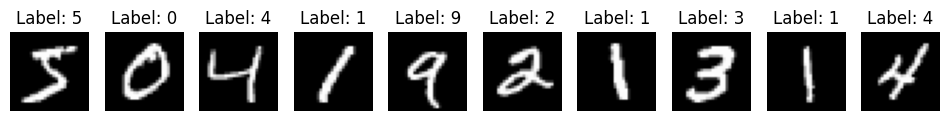

In [4]:
# Plot some images from the dataset
def plot_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i, (image, label) in enumerate(dataset):
        if i >= num_images:
            break
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

plot_images(train_set)

In [5]:
# Print dimensionalities
print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 60000
Test set size: 10000


In [6]:
# Display shapes of inputs (images and labels)
for batch_idx, (images, labels) in enumerate(training_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break  # Print the shape of the first batch onl

Batch 1:
Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


<h2>Implemenation of encoder, decoder and quantizer</h2>

<h5>Resnet Block Implementation</h5>

In [7]:

# Define the Residual block and ResidualBlocks class
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super(Residual, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )

    def forward(self, x):
        residual = x
        x = self.block(x)
        x = x + residual  # Add the input tensor to the output of the block
        return x

class ResidualBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, residual_layers, hidden_channels):
        super(ResidualBlocks, self).__init__()
        self.residual_layers = residual_layers
        self.layers = nn.ModuleList(
            [
                Residual(in_channels, out_channels, hidden_channels)
                for _ in range(self.residual_layers)
            ]
        )

    def forward(self, x):
        for i in range(self.residual_layers):
            x = x + self.layers[i](x)
            x = F.relu(x)
        return x


In [8]:
# Function to check output of Residual block
def check_residual_output():
    # Define input tensor
    input_tensor = torch.randn(1, 64, 28, 28)  # Example input tensor with specified dimensions

    # Initialize Residual block with specified parameters
    residual_block = Residual(in_channels=64, out_channels=64, hidden_channels=32)

    # Pass input through the Residual block
    output = residual_block(input_tensor)

    # Print output shape
    print(f"Output shape: {output.shape}")
    return output

# Call the function to check the output of the Residual block
residual_output = check_residual_output()

Output shape: torch.Size([1, 64, 28, 28])


In [9]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels=128, hidden_layers=32, residual_layers=2):
        super(Encoder, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 2, 4, 2, 1),
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 4, 2, 1),
            nn.ReLU()
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU()
        )
        self.residual_block = ResidualBlocks(out_channels, out_channels, residual_layers, hidden_layers)

    def forward(self, x):
        x = self.layer_1(x)
        #print(f"Layer 1 output shape: {x.shape}")

        x = self.layer_2(x)
        #print(f"Layer 2 output shape: {x.shape}")

        x = self.layer_3(x)
        #print(f"Layer 3 output shape: {x.shape}")

        x = self.residual_block(x)
        #print(f"Residual block output shape: {x.shape}")

        return x



In [10]:
# Function to check the dimensions of the Encoder output
def check_encoder_dimensions():
    # Assuming 3 channels for the input tensor
    in_channels = 3
    sample_input = torch.randn(1, in_channels, 64, 64)  # Creating a sample input tensor

    # Initialize the Encoder
    encoder = Encoder(in_channels=in_channels)

    # Pass the sample input through the Encoder
    output = encoder(sample_input)

    # Return the final output shape
    return output.shape

# Call the function to check the dimensions of the Encoder output
encoder_output_shape = check_encoder_dimensions()
print(f"Final Encoder output shape: {encoder_output_shape}")


Final Encoder output shape: torch.Size([1, 128, 16, 16])


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the VectorQuantization class
class VectorQuantization(nn.Module):
    def __init__(self, number_embeddings, embedding_dimension):
        super(VectorQuantization, self).__init__()

        self.num_embeddings = number_embeddings
        self.embedding_dim = embedding_dimension

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)

        # Assuming 'device' is defined elsewhere in the code
        self.embedding.weight.data.uniform_(-1 / self.num_embeddings, 1 / self.num_embeddings)

    def forward(self, x):
        # Convert (Batch, channel, Height, Width) to (Batch, Height, Width, Channel) for flattening
        x = x.permute(0, 2, 3, 1)

        # Flatten input
        latent = x.reshape(-1, self.embedding_dim)

        # Calculate the L2 Norm between latent and Embedded weights
        distances = (torch.sum(latent**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(latent, self.embedding.weight.t()))

        # Encoding starts from here
        encoded_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # One Hot Encoding starts from here
        encoded_vector = F.one_hot(encoded_indices, self.num_embeddings).type(x.dtype)
        encoded_vector = encoded_vector.view(encoded_vector.shape[0], encoded_vector.shape[2])

        # Quantization of the Encodings
        quantized_vector = torch.matmul(encoded_vector, self.embedding.weight)

        # Bringing back to the original shape
        quantized_vector = quantized_vector.view(x.shape)

        # Loss calculation
        beta = 0.25  # Hyperparameter
        commitment_loss = F.mse_loss(quantized_vector.detach(), x)
        codebook_loss = F.mse_loss(quantized_vector, x.detach())
        vq_loss = codebook_loss + beta * commitment_loss

        # Detach and update quantized vector for backpropagation
        quantized_vector = x + (quantized_vector - x).detach()
        quantized_vector = quantized_vector.permute(0, 3, 1, 2)

        return quantized_vector, vq_loss



Quantized output shape: torch.Size([1, 3, 64, 64])
VQ Loss: 1.0680049657821655


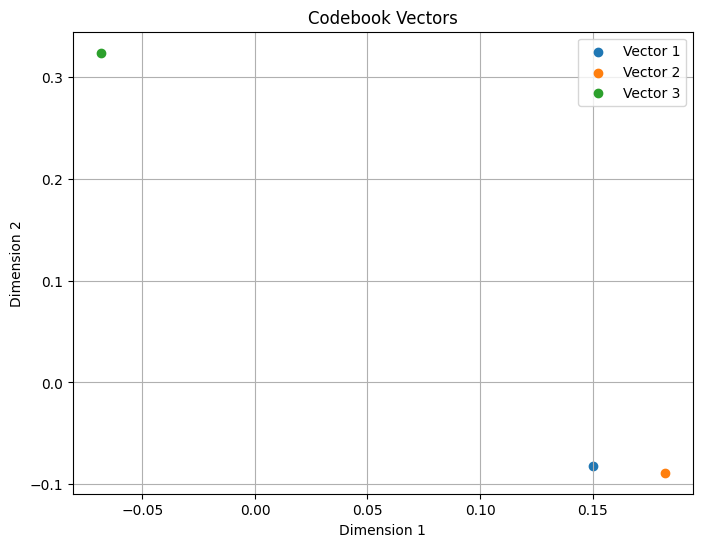

In [12]:
import matplotlib.pyplot as plt

# Function to plot 2D vectors from the codebook
def plot_codebook_vectors(vq_module):
    # Get the codebook vectors
    codebook = vq_module.embedding.weight.data.cpu().numpy()

    # Plot each 2D vector from the codebook
    plt.figure(figsize=(8, 6))
    for i in range(len(codebook)):
        plt.scatter(codebook[i][0], codebook[i][1], label=f'Vector {i+1}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Codebook Vectors')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot codebook vectors after checking VectorQuantization output
def check_and_plot_codebook():
    # Assuming 3 channels for the input tensor (modify as needed)
    in_channels = 3
    sample_input = torch.randn(1, in_channels, 64, 64)  # Creating a sample input tensor

    # Initialize the VectorQuantization module
    vq = VectorQuantization(number_embeddings=3, embedding_dimension=2)

    # Pass the sample input through the VectorQuantization module
    quantized_output, vq_loss = vq(sample_input)

    # Print the output shape and loss
    print(f"Quantized output shape: {quantized_output.shape}")
    print(f"VQ Loss: {vq_loss}")

    # Plot codebook vectors
    plot_codebook_vectors(vq)

# Call the function to check the output and plot codebook vectors
check_and_plot_codebook()


In [13]:
class Decoder(nn.Module):
    def __init__(self, out_channels=128, residual_layers=2, hidden_layers=32):
        super(Decoder, self).__init__()

        self.inverse_residual_block = ResidualBlocks(out_channels,out_channels,residual_layers,hidden_layers)

        self.trans_layer1 = nn.Sequential(
                                    nn.ConvTranspose2d(out_channels,out_channels//2,4,2,1),
                                    nn.ReLU()
        )
        self.trans_layer2 = nn.Sequential(
                                    nn.ConvTranspose2d(out_channels//2,3,4,2,1),
        )

    def forward(self, x):
        x = self.inverse_residual_block(x)
        x = self.trans_layer1(x)
        x = self.trans_layer2(x)
        return x

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Define a simple input tensor for testing
def generate_sample_input(batch_size, out_channels, height, width):
    return torch.randn(batch_size, out_channels, height, width)

# Define a check function for the Decoder class
def check_decoder():
    # Assuming dimensions for the test input
    batch_size = 1
    out_channels = 128
    height = 32
    width = 32

    # Creating a sample input tensor
    sample_input = generate_sample_input(batch_size, out_channels, height, width)

    # Initialize the Decoder module
    decoder = Decoder(out_channels=out_channels, residual_layers=2, hidden_layers=32)

    # Pass the sample input through the Decoder module
    output = decoder(sample_input)

    # Print the output shape
    print(f"Decoder Output Shape: {output.shape}")

# Call the function to check the Decoder class
check_decoder()


Decoder Output Shape: torch.Size([1, 3, 128, 128])


## Define and train the network

In [15]:

class VQVAENet(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, in_channels=1):
        super(VQVAENet, self).__init__()
        self.encoder = Encoder(in_channels)
        self.hidden1 = nn.Conv2d(128, embedding_dim, 1, 1)
        self.vq = VectorQuantization(num_embeddings, embedding_dim)
        self.hidden2 = nn.Conv2d(embedding_dim, 128, 3, 1, 1)
        self.decoder = Decoder()  # Use the modified Decoder

    def forward(self, x):
        x = self.encoder(x) #outputs an image of size (batch x 128 x original_width x original_height)

        x = self.hidden1(x) #outputs an image of size (batch x 64 x width x height)

        quantized_vector,vq_loss= self.vq(x) #No change in size of image

        x = self.hidden2(quantized_vector) #outputs an image of size (batch x 128 x width x height)

        x = self.decoder(x) #outputs image with dimensions of original image

        return x,vq_loss

In [16]:
model = VQVAENet(3,2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [17]:
#Hyperparameters
batch_size = 128


In [18]:

from tqdm.notebook import tqdm
# Define a function to train the model
def train(data_loader):
    recon_losses = []
    vq_losses = []
    total_losses = []
    codebook_vectors = []

    model.train()
    for data, _ in tqdm(training_loader, desc="Training", unit="batch"):
        data = data.to(device)
        optimizer.zero_grad()
        output, vq_loss = model(data)
        recon_loss = F.mse_loss(output, data)
        loss = recon_loss + vq_loss
        loss.backward()
        optimizer.step()
        recon_losses.append(recon_loss.item())
        vq_losses.append(vq_loss.item())
        total_losses.append(loss.item())
        codebook_vectors.append(model.vq.embedding.weight.clone().detach().cpu().numpy())

    return recon_losses, vq_losses, total_losses, codebook_vectors

Recon_loss, VQ_loss, Total_loss, Codebook_vectors = train(training_loader)

Training:   0%|          | 0/938 [00:00<?, ?batch/s]

/tmp/ipykernel_42/2138133227.py:14: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([64, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(output, data)
/tmp/ipykernel_42/2138133227.py:14: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(output, data)


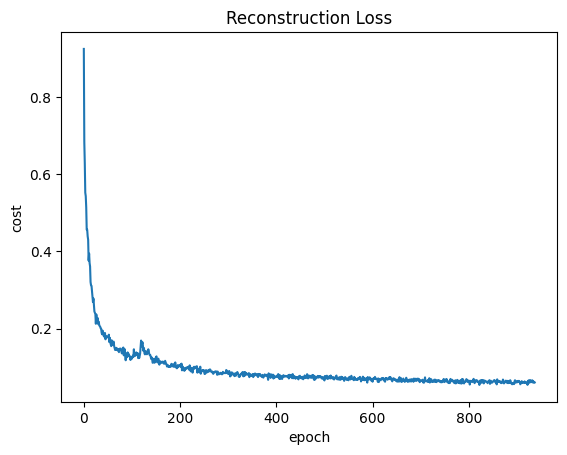

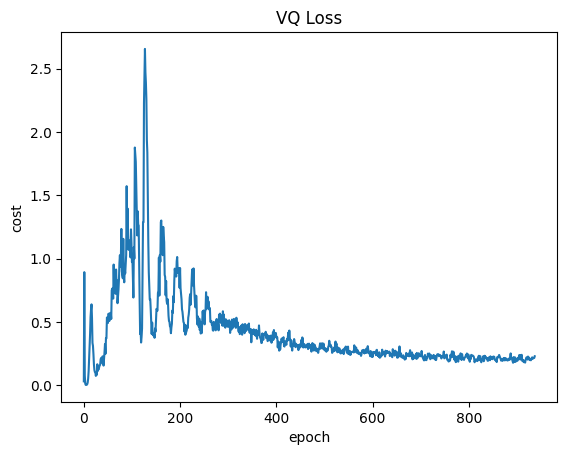

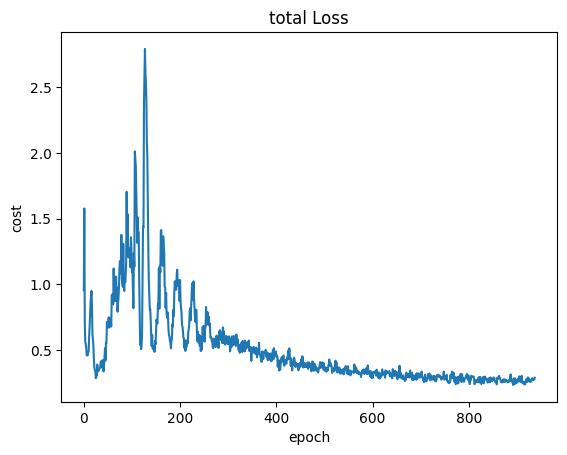

In [19]:

#plotting Recon Loss
plt.plot(Recon_loss)
plt.title("Reconstruction Loss")
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()

#plotting vq-loss
plt.plot(VQ_loss)
plt.title("VQ Loss")
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()

#plotting vq-loss
plt.plot(Total_loss)
plt.title("total Loss")
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()


In [20]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Plotting Recon Loss
recon_loss_trace = go.Scatter(x=list(range(len(Recon_loss))), y=Recon_loss, mode='lines')
layout_recon_loss = go.Layout(title='Reconstruction Loss', xaxis=dict(title='epoch'), yaxis=dict(title='cost'))
fig_recon_loss = go.Figure(data=[recon_loss_trace], layout=layout_recon_loss)
pyo.iplot(fig_recon_loss)

# Plotting VQ Loss
vq_loss_trace = go.Scatter(x=list(range(len(VQ_loss))), y=VQ_loss, mode='lines')
layout_vq_loss = go.Layout(title='VQ Loss', xaxis=dict(title='epoch'), yaxis=dict(title='cost'))
fig_vq_loss = go.Figure(data=[vq_loss_trace], layout=layout_vq_loss)
pyo.iplot(fig_vq_loss)

# Plotting Total Loss
total_loss_trace = go.Scatter(x=list(range(len(Total_loss))), y=Total_loss, mode='lines')
layout_total_loss = go.Layout(title='Total Loss', xaxis=dict(title='epoch'), yaxis=dict(title='cost'))
fig_total_loss = go.Figure(data=[total_loss_trace], layout=layout_total_loss)
pyo.iplot(fig_total_loss)


In [21]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Extract X and Y coordinates for each codebook vector across iterations
num_iterations = len(Codebook_vectors)
print(num_iterations)
codebook_1 = np.zeros((num_iterations, 2))
codebook_2 = np.zeros((num_iterations, 2))
codebook_3 = np.zeros((num_iterations, 2))

for i, codebook_vector in enumerate(Codebook_vectors):
    codebook_1[i] = codebook_vector[0,:]
    codebook_2[i] = codebook_vector[1,:]
    codebook_3[i] = codebook_vector[2,:]



938


In [22]:
codebook_vectors = []
input_images = []
output_images = []

# Iterate through the training loader to generate codebook vectors and images
for i, (image, _) in enumerate(tqdm(training_loader, desc="Generating codebook vectors and images", unit="batch")):
    image = image.to(device)
    out_image, vq_loss = model(image)

    # Reshape output to separate individual images in the batch
    out_image = out_image.view(-1, 28, 28).cpu().detach().numpy()

    # Collect codebook vectors for each iteration
    x_coords = [codebook_1[i, 0], codebook_2[i, 0], codebook_3[i, 0]]
    y_coords = [codebook_1[i, 1], codebook_2[i, 1], codebook_3[i, 1]]
    codebook_vectors.append(np.column_stack((x_coords, y_coords)))

    # Collect input and output images for each iteration
    input_images.append(image[0].cpu().squeeze().numpy())  # Assuming batch size is 1
    output_images.append(out_image[0])  # Assuming batch size is 1


Generating codebook vectors and images: 100%|██████████| 938/938 [01:09<00:00, 13.50batch/s]


In [23]:

num_frames = 500
codebook_vectors = codebook_vectors[:num_frames]
input_images = input_images[:num_frames]
output_images = output_images[:num_frames]


# Function to update the plot for each frame
def update_plot(i):
    plt.clf()

    # Plot codebook vectors
    plt.scatter(codebook_vectors[i][:, 0], codebook_vectors[i][:, 1], c=['r', 'g', 'b'], marker='o', label='Codebook Vectors')
    plt.xlim(-1, 1)  # Set x-axis limits
    plt.ylim(-1, 1)  # Set y-axis limits


# Create the figure and animation
fig = plt.figure(figsize=(15, 5))



<Figure size 1500x500 with 0 Axes>

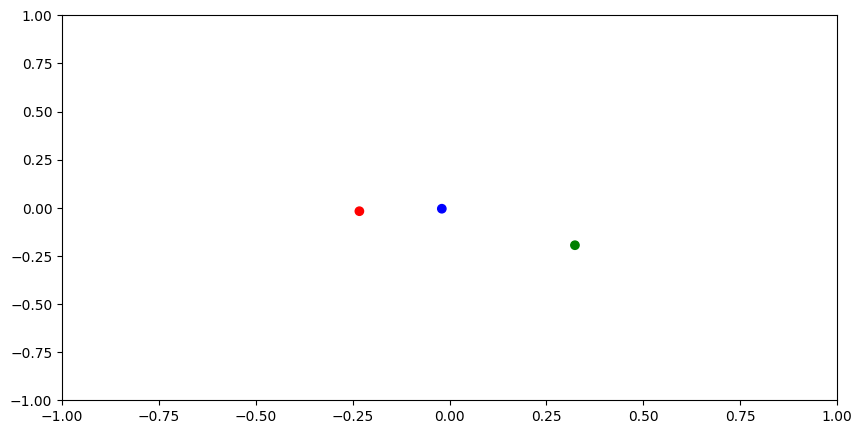

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tqdm import tqdm

# Create the figure and animation
fig = plt.figure(figsize=(10, 5))
ani = animation.FuncAnimation(fig, update_plot, frames=len(codebook_vectors), interval=200)

# Save the animation as a GIF
ani.save('codebook_animation.gif', writer='pillow', fps=20)



In [25]:

# Function to update the plot for each frame
def update_plot(i):
    plt.clf()

    # Plot input image
    plt.subplot(1, 2, 1)
    plt.imshow(input_images[i], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # Plot output image
    plt.subplot(1, 2, 2)
    plt.imshow(output_images[i], cmap='gray')
    plt.title('Output Image')
    plt.axis('off')

# Create the figure and animation
fig = plt.figure(figsize=(15, 5))


<Figure size 1500x500 with 0 Axes>

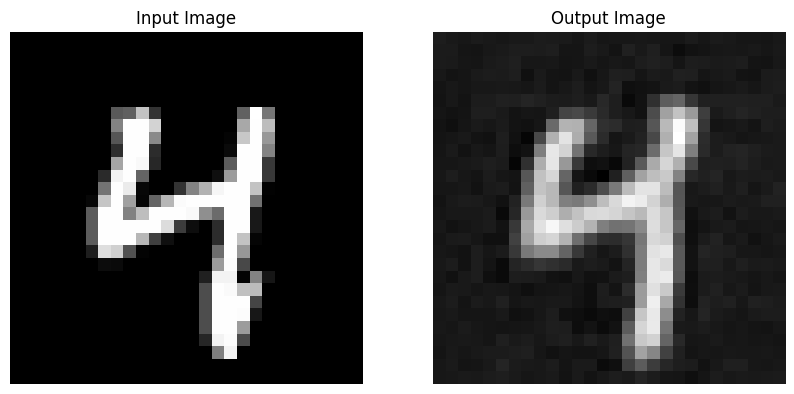

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tqdm import tqdm

# Create the figure and animation
fig = plt.figure(figsize=(10, 5))
ani = animation.FuncAnimation(fig, update_plot, frames=len(codebook_vectors), interval=200)

# Save the animation as a GIF
ani.save('output.gif', writer='pillow', fps=20)

# Display the animation (optional)

In [27]:
from IPython.display import HTML

# Display the GIFs in an infinite loop
output_animation_path = 'output_animation.gif'
codebook_animation_path = 'codebook_animation.gif'



## Codebook and images animation 

In [ ]:
import base64
from IPython.display import display, HTML

# Paths to the GIFs
output_animation_path = 'output.gif'
codebook_animation_path = 'codebook_animation.gif'

# Load the GIFs as base64-encoded strings
with open(output_animation_path, "rb") as output_file:
    output_animation = base64.b64encode(output_file.read()).decode('utf-8')
with open(codebook_animation_path, "rb") as codebook_file:
    codebook_animation = base64.b64encode(codebook_file.read()).decode('utf-8')
display(HTML(f'<img src="data:image/gif;base64,{output_animation}" /> \
                  <img src="data:image/gif;base64,{codebook_animation}" />'))


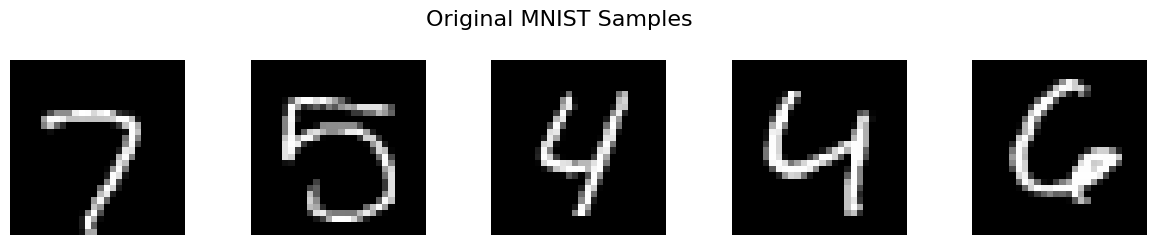

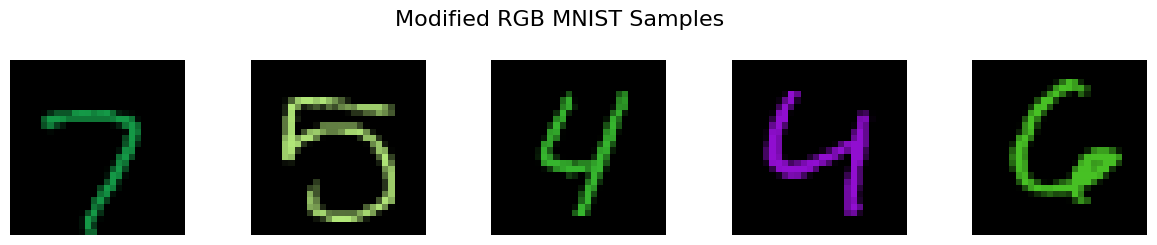

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from torch.utils.data import Dataset, DataLoader
# Load MNIST dataset
(train_images, train_labels), _ = mnist.load_data()

# Select 5 random samples
sample_indices = np.random.choice(len(train_images), 5)

# Plot original images
plt.figure(figsize=(15, 5))
plt.suptitle('Original MNIST Samples', fontsize=16)
for i, index in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[index], cmap='gray')
    plt.axis('off')

# Convert images to RGB by replicating the single channel across three channels
train_images_rgb = np.stack((train_images,) * 3, axis=-1)

# Generate random multipliers for each channel of each image
random_multipliers = np.random.rand(len(train_images), 1, 1, 3)

# Multiply pixels by random multipliers for each channel
train_images_rgb = (train_images_rgb * random_multipliers).astype(np.uint8)  # Convert back to uint8
class ColoredMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define a transformation to convert numpy array to PyTorch tensor and normalize pixel values
custom_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the numpy array to a PyTorch tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize pixel values
])
colored_mnist_dataset = ColoredMNISTDataset(train_images_rgb, train_labels, transform=custom_transform)
# Plot modified RGB images
plt.figure(figsize=(15, 5))
plt.suptitle('Modified RGB MNIST Samples', fontsize=16)
for i, index in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images_rgb[index])
    plt.axis('off')

plt.show()


In [56]:
models = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in range(6):
    if i < 3:
        # For the first 3 models, fix num_embeddings and change embedding_dim
        model = VQVAENet(5, i+3,3).to(device)  # Fixed num_embeddings=5, embedding_dim varies from 3 to 5
    else:
        # For the next 3 models, fix embedding_dim and change num_embeddings
        model = VQVAENet(10*i, 3,3).to(device)  # Fixed embedding_dim=3, num_embeddings varies from 10 to 30
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    models.append((model, optimizer))

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to train a model
def train_model(model, optimizer, data_loader):
    recon_losses = []
    vq_losses = []
    total_losses = []

    model.train()
    for data, _ in tqdm(data_loader, desc="Training", unit="batch"):
        data = data.to(device)
        optimizer.zero_grad()
        output, vq_loss = model(data)
        recon_loss = F.mse_loss(output, data)
        loss = recon_loss + vq_loss
        loss.backward()
        optimizer.step()
        recon_losses.append(recon_loss.item())
        vq_losses.append(vq_loss.item())
        total_losses.append(loss.item())

    return recon_losses, vq_losses, total_losses

# Training loop for all 6 models
losses = []

for idx, (model, optimizer) in enumerate(models):
    print(f"Training Model {idx + 1}...")
    train_loader = DataLoader(colored_mnist_dataset, batch_size=32, shuffle=True)  # Use your DataLoader here
    recon_losses, vq_losses, total_losses = train_model(model, optimizer, train_loader)
    losses.append((recon_losses, vq_losses, total_losses))


Training Model 1...


Training: 100%|██████████| 1875/1875 [03:07<00:00,  9.99batch/s]


Training Model 2...


Training: 100%|██████████| 1875/1875 [02:59<00:00, 10.46batch/s]


Training Model 3...


Training: 100%|██████████| 1875/1875 [02:57<00:00, 10.56batch/s]


Training Model 4...


Training: 100%|██████████| 1875/1875 [02:57<00:00, 10.54batch/s]


Training Model 5...


Training: 100%|██████████| 1875/1875 [03:01<00:00, 10.34batch/s]


Training Model 6...


Training: 100%|██████████| 1875/1875 [02:59<00:00, 10.46batch/s]


In [70]:
import plotly.graph_objs as go

# Your previous code for training models and collecting losses here...

fig1 = go.Figure()
fig2 = go.Figure()

descriptions = [
    "Fixed num_embeddings=5 embedding_dim=3,5",

    # Descriptions for the first 3 models
    "Fixed embedding_dim=3, num_embeddings=10,30",  # Descriptions for the next 3 models

]

for i, (recon_losses, vq_losses, total_losses) in enumerate(losses):
    iterations = list(range(len(total_losses)))  # Convert range to a list
    model_description = descriptions[i // 3]  # Assign model description based on the model's group

    trace = go.Scatter(x=iterations, y=total_losses, mode='lines', name=f"Model {i + 1} ({model_description})")

    if i < 3:
        fig1.add_trace(trace)  # Add traces for the first 3 models to fig1
    else:
        fig2.add_trace(trace)  # Add traces for the next 3 models to fig2

fig1.update_layout(
    title='Total Loss vs. Iterations (Models 1-3)',
    xaxis_title='Iterations',
    yaxis_title='Total Loss',
    legend_title='Models'
)

fig2.update_layout(
    title='Total Loss vs. Iterations (Models 4-6)',
    xaxis_title='Iterations',
    yaxis_title='Total Loss',
    legend_title='Models'
)

fig1.show()
fig2.show()


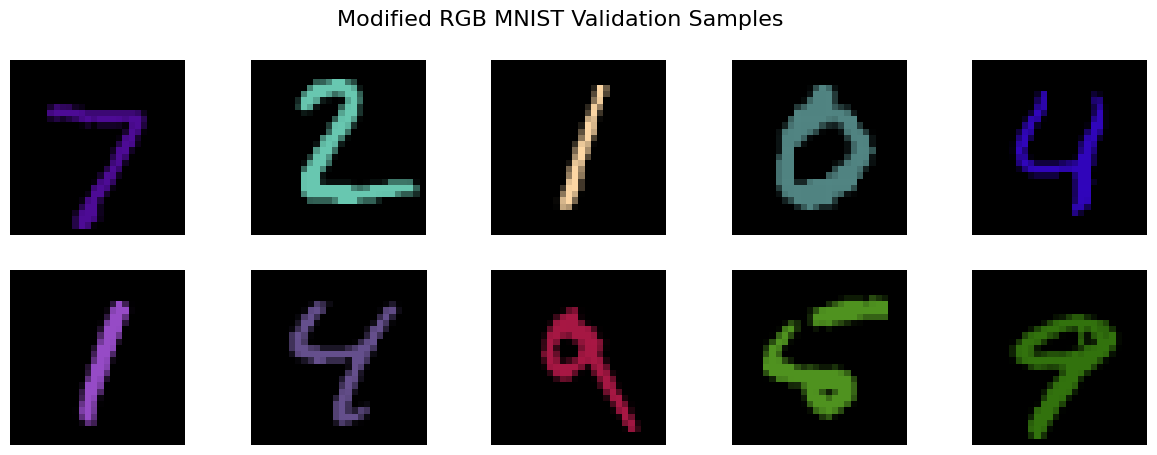

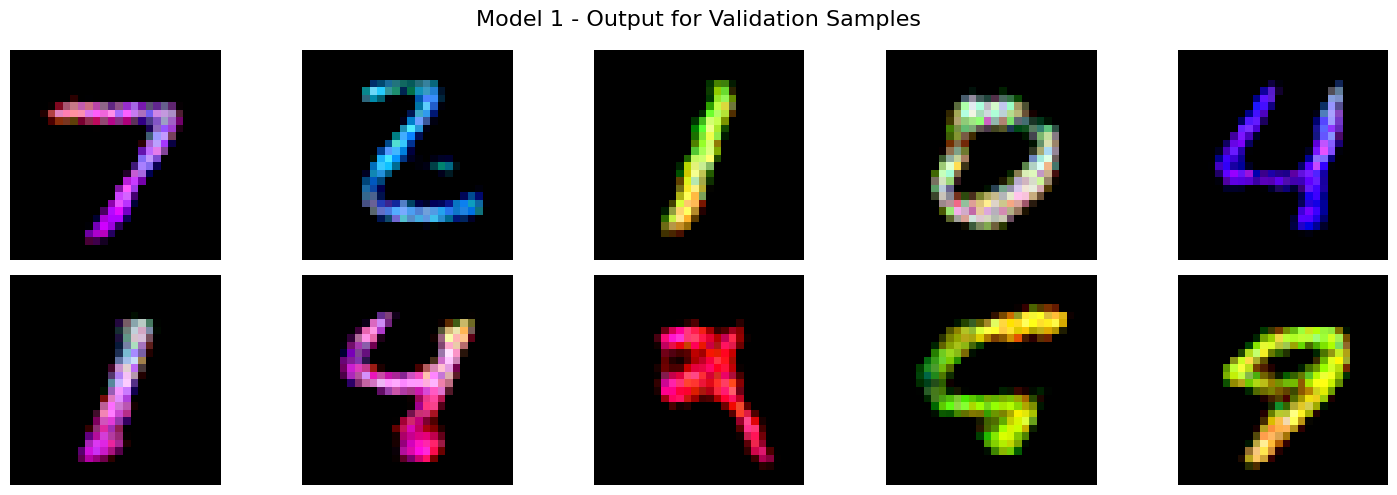

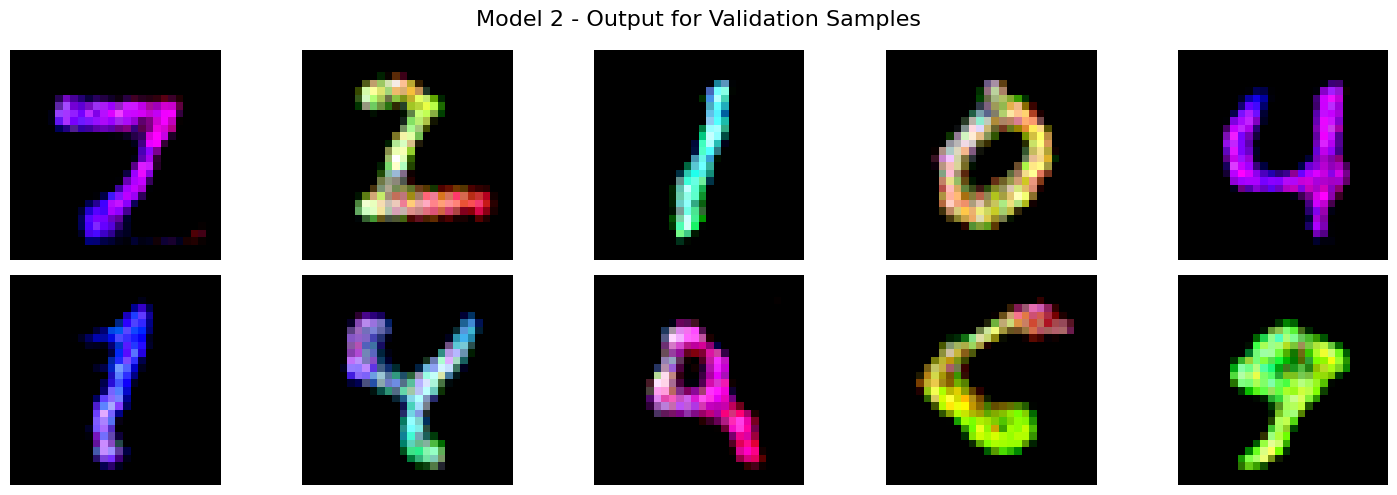

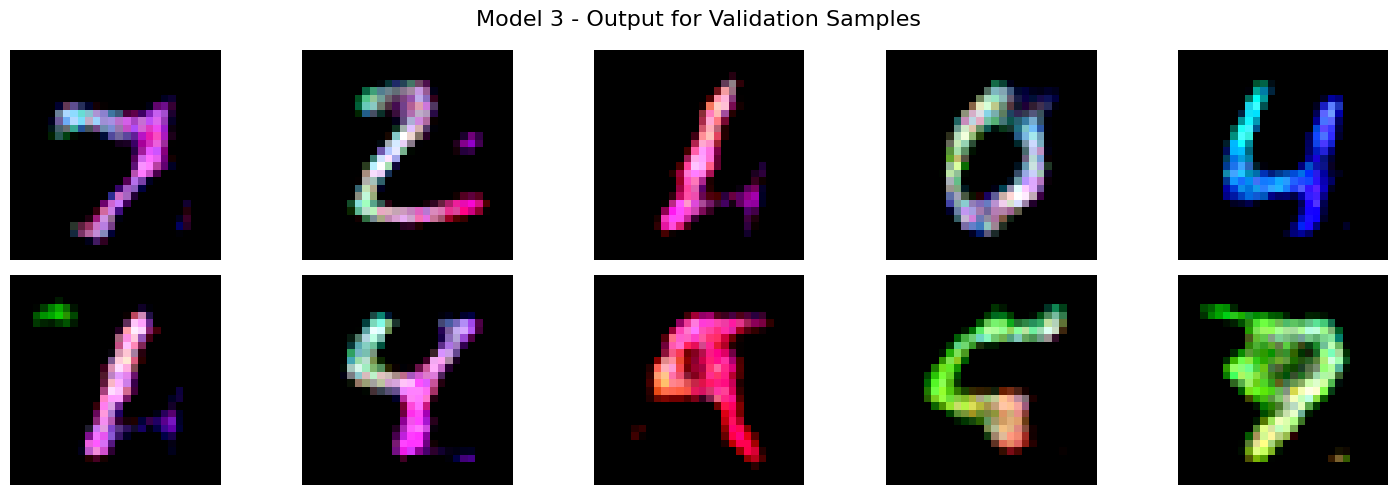

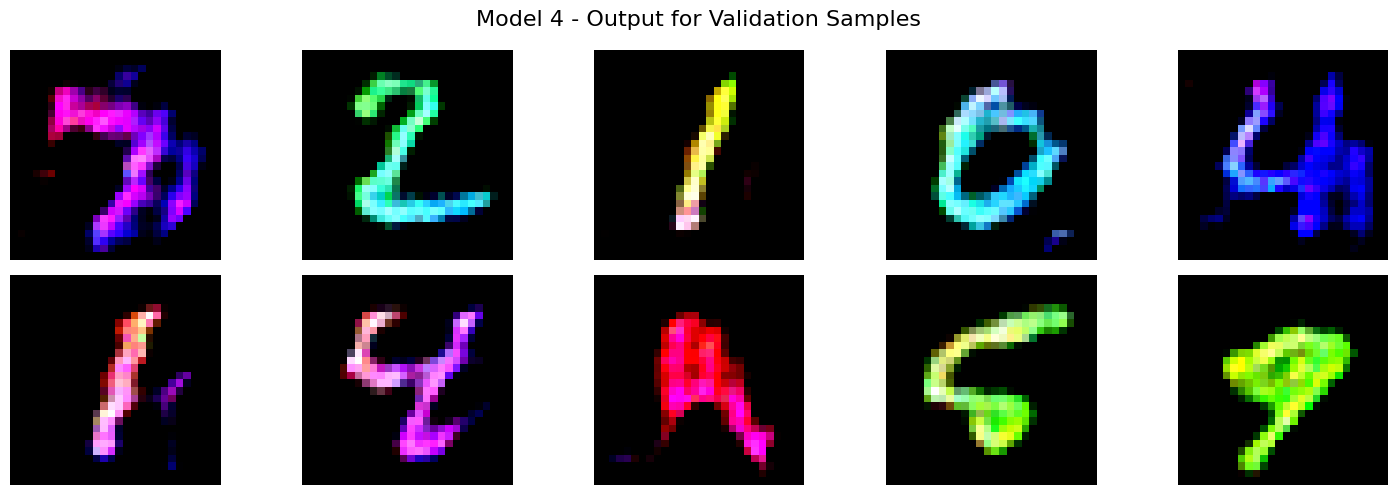

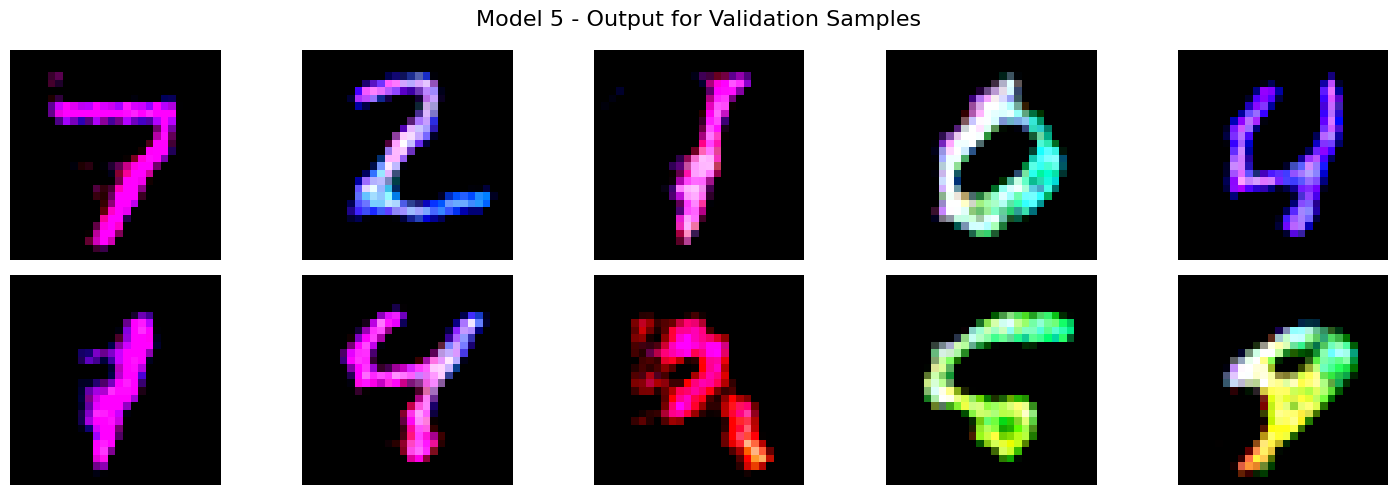

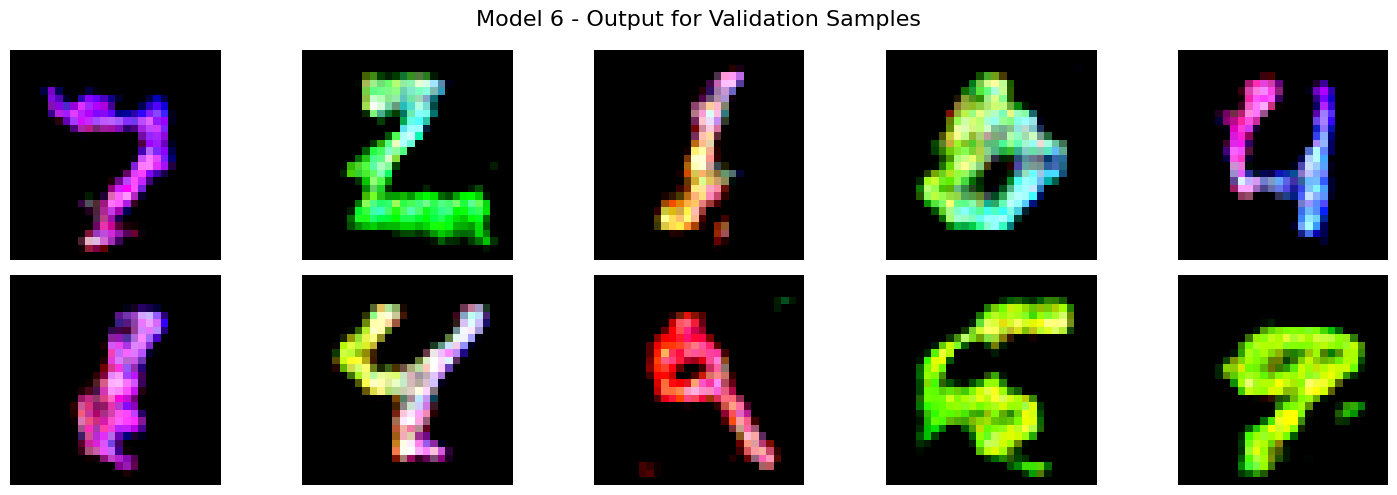

In [68]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import numpy as np
import torch

# Load MNIST test dataset
(_, _), (test_images, test_labels) = mnist.load_data()

# Convert validation images to RGB similar to the training images
val_images_rgb = np.stack((test_images,) * 3, axis=-1)
random_multipliers_val = np.random.rand(len(test_images), 1, 1, 3)
val_images_rgb = (val_images_rgb * random_multipliers_val).astype(np.uint8)

# Define a new dataset for the validation set
colored_val_dataset = ColoredMNISTDataset(val_images_rgb, test_labels, transform=custom_transform)

# Plot 10 samples from the validation set
plt.figure(figsize=(15, 5))
plt.suptitle('Modified RGB MNIST Validation Samples', fontsize=16)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(val_images_rgb[i])
    plt.axis('off')

plt.show()

# Now, load the models (models 1 to 6) and generate outputs for the validation set
outputs_val = []
for i, (model, _) in enumerate(models):
    model_output_val = []
    for idx in range(10):  # Considering 10 samples for visualization
        input_image_val = torch.tensor(val_images_rgb[idx], dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2)
        model.eval()
        with torch.no_grad():
            output_val, _ = model(input_image_val)
        model_output_val.append(output_val.squeeze().permute(1, 2, 0).cpu().numpy())
    outputs_val.append(model_output_val)

# Plot the 10 validation samples alongside outputs of models 1 to 6
for i, output_val in enumerate(outputs_val):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Model {i + 1} - Output for Validation Samples", fontsize=16)
    for j in range(10):
        plt.subplot(2, 5, j + 1)
        plt.imshow(output_val[j])
        plt.axis('off')
    plt.tight_layout()
    plt.show()





# Theory:
The codebook in VQVAE represents discrete latent space vectors. The size of the codebook determines the number of possible discrete latent representations or embeddings that can be learned by the model. Larger codebook sizes allow for a more fine-grained representation of the input data, enabling the model to capture more intricate details and nuances. Conversely, a smaller codebook size limits the diversity of representations, potentially causing the model to lose some information during the encoding process.

### Dimension of the Codebook Vectors:
The dimension of the codebook vectors defines the space in which the latent representations are embedded. Higher-dimensional embeddings provide a more expressive space for capturing complex patterns and variations in the input data. This can lead to higher fidelity reconstructions and better preservation of input details. On the other hand, lower-dimensional embeddings may result in a more compressed representation, potentially losing some fine-grained details but requiring fewer parameters.

### Impact on Generated Output:
- **Codebook Size**: A larger codebook size generally leads to higher fidelity reconstructions as it allows for a wider variety of learned representations. However, it may increase computational complexity and memory requirements.
- **Dimension of Codebook Vectors**: Higher dimensions enable more detailed and complex representations but may require more data and computational resources to train effectively.

# Practical Results:
- what we found out in this notebook is that models with a very large codebook seem to make unclear, messy outputs, and simpler models done significantly better
## Model 6 with 3D,30 embeddings resulted in worst results and Model 1 with only one embedding, 3D was the best model

**Refrence:**
https://arxiv.org/pdf/1711.00937.pdf